# Package import 

In [109]:
import pandas as pd
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, fisher_exact, mannwhitneyu, chi2_contingency
#Customs functions 
package_path = '..'
sys.path.insert(0, package_path)
from functions.descriptive import *
from functions.varplots import *

# Functions

In [110]:
def plot_var(X, to_drop):
    data = X.drop(columns=to_drop)
    y = None
    N_features = 7
    N_col = 3
    if N_features%N_col == 0:
        n_rows = np.int64(N_features/N_col)
    else:
        n_rows = np.int64(N_features/N_col) + 1

    # plot recursivly according to the type of variables
    fig, ax = plt.subplots(nrows=n_rows, ncols=N_col, figsize = (10,10))
    fig.tight_layout(pad=5.0)
    ind_row = 0
    ind_col = 0
    for i in data.columns:
        # print(i)
        if N_col == ind_col:
            ind_col = 0 
            ind_row += 1 
        if i in data.select_dtypes('category').columns.tolist():
            g = sns.countplot(data=  data, x=str(i), ax=ax[ind_row][ind_col], hue=y)
            #g.set(ylim=(0, 150))
            for p in ax[ind_row][ind_col].patches:
                ax[ind_row][ind_col].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()-10))
            ind_col += 1  
        elif i in data.select_dtypes(exclude='category').columns.tolist():
            g = sns.kdeplot(data =  data, x=str(i), hue=y, ax=ax[ind_row][ind_col], multiple="stack")
            ind_col +=1


    title = "Density plots and barplots of variables.png"
    plt.suptitle(str(title))


from scipy import stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def run_cramers(data, target_column, informative_col):
    data_categorical = data.drop(target_column + informative_col, axis=1).select_dtypes(['object', 'category'])
    cramers_value_dict = {}
    for col1 in data_categorical:
        cramers_value_dict[col1] = {}
        for col2 in data_categorical:
            confusion_matrix = pd.crosstab(data_categorical[col1], data_categorical[col2])
            cramers_value = round(cramers_corrected_stat(confusion_matrix.values), 2)
            cramers_value_dict[col1][col2] = cramers_value
    
    cramers_value_df = pd.DataFrame.from_dict(cramers_value_dict)
    return(cramers_value_df)

def kruskal_test(data, continuous_feature, categorical_feature):
    x = data[categorical_feature]
    y = data[continuous_feature]

    # find unique group labels and their corresponding indices
    label, idx = np.unique(x, return_inverse=True)

    # make a list of arrays containing the y-values corresponding to each unique label
    groups = [y[idx == i] for i, l in enumerate(label)]
    
    H, p = kruskal(*groups)
    
    return(p)

def run_kruskal(data, target_column, informative_col):
    data_temp = data.dropna().drop(target_column + informative_col, axis=1)
    data_categorical = data_temp.select_dtypes(['object', 'category'])
    data_numerical = data_temp.select_dtypes(['float'])
    kruskal_value_dict = {}
    for col1 in data_categorical:
        kruskal_value_dict[col1] = {}
        for col2 in data_numerical:
            p_value = kruskal_test(data_temp, col2, col1)
            p_value = round(p_value, 2)
            kruskal_value_dict[col1][col2] = p_value
    
    kruskal_value_df = pd.DataFrame.from_dict(kruskal_value_dict)
    return(kruskal_value_df)

def plot_correlation_matrix(corr: pd.DataFrame, ax, data_type):

    # Generate a mask for the upper triangle
    if data_type != 'mixed':
        mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    #f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    if data_type != 'mixed':
        ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0.5,
                         square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        ax = sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
                         square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    if data_type == 'numerical':
        ax.set(title=f'Kendall correlation for {data_type} variables')
    elif data_type == 'categorical':
        ax.set(title=f'Cramers correlation for {data_type} variables')
    elif data_type == 'mixed':
        ax.set(title=f'Kruskrall correlation for {data_type} variables')

# Introduction and data import 

This is all dataset we have available in the folder

In [3]:
os.listdir(path=r'C:\Users\mehdy\Desktop\Work\KAGGLE\Parkison-s-freezing\data\tlvmc-parkinsons-freezing-gait-prediction')

['daily_metadata.csv',
 'defog_metadata.csv',
 'events.csv',
 'sample_submission.csv',
 'subjects.csv',
 'tasks.csv',
 'tdcsfog_metadata.csv',
 'test',
 'train',
 'unlabeled']

- daily_meta contains data from 65 people with PD that were recorded using the same device as in the home FoG-provoking dataset (the DeFOG dataset)
- defrog meta contains one condition (Visit subject and medication) for each series in defog dataset 
- events meta data for each FOG event in all data series 
- sample submission example of submission file in kaggle 
- subject meata data for each subject with age, sex ...
- task meata data for defog data set 
- tdsc metadata for tdsc dataset 
- test contain test patient
- train contain :
  - defog dataset, comprising data series collected in the subject's home, as subjects completed a FOG-provoking protocol
  - tdsc dataset, comprising data series collected in the lab, as subjects completed a FOG-provoking protocol.
  - notype data

In [4]:
# Import data
defog_train_1 = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/train/defog/02ea782681.csv')
defog_metadata = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
daily_metadata = pd.read_csv("../data/tlvmc-parkinsons-freezing-gait-prediction/daily_metadata.csv")
events = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/events.csv')
subject = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/subjects.csv')
tasks = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/tasks.csv')
tdcsfod_metadata = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
defog_test = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/test/defog/02ab235146.csv')
tdsc_test = pd.read_csv('../data/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/003f117e14.csv')

# Exploratory analysis
## subject data

In [74]:
subject 

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0
2,0967b2,1.0,59,M,10.0,38.0,48.0,19
3,0967b2,2.0,59,M,10.0,37.0,44.0,13
4,097078,NaN,70,F,10.0,27.0,50.0,20
...,...,...,...,...,...,...,...,...
168,f90887,1.0,72,M,16.0,35.0,46.0,26
169,fc1e1b,1.0,82,F,11.0,38.0,42.0,21
170,fe5d84,2.0,72,M,14.0,32.0,45.0,17
171,fe5d84,1.0,72,F,14.0,13.0,33.0,15


### Data description

In [101]:
#missing values 
descrip = Descriptive_analysis()
descrip.missing_values(subject)

,Variables,Nans
0,Visit,62
1,UPDRSIII_Off,41
2,UPDRSIII_On,1


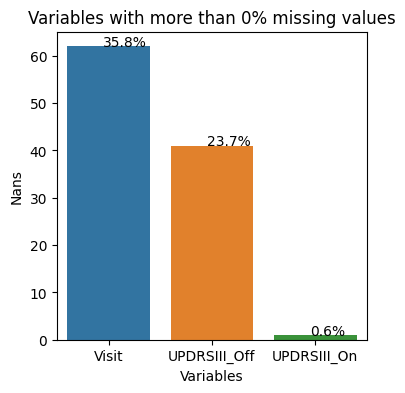

In [108]:
descrip.plot_missing_values(subject, threshold=0, fig_size=[4,4])

In [75]:
#convert data dtypes 
subject[[  'Visit',  'Sex']] = subject[[  'Visit',  'Sex']].astype('category')
subject.Subject = subject.Subject.astype('str')
subject.dtypes

Subject           object
Visit           category
Age                int64
Sex             category
YearsSinceDx     float64
UPDRSIII_On      float64
UPDRSIII_Off     float64
NFOGQ              int64
dtype: object

In [82]:
#describe data 
print('Continuous variables')
print(subject.describe().T)
print('categorical variables')
print(subject.select_dtypes('category').apply(lambda x:  x.value_counts()))

Continuous variable
              count       mean        std    min   25%   50%    75%   max
Age           173.0  67.763006   7.972075  28.00  62.0  68.0  73.00  94.0
YearsSinceDx  173.0  10.383931   6.289191   0.42   6.0   9.0  15.00  30.0
UPDRSIII_On   172.0  34.273256  12.732552   5.00  25.0  35.0  42.25  79.0
UPDRSIII_Off  132.0  42.878788  12.998550  15.00  33.0  43.0  49.25  91.0
NFOGQ         173.0  17.121387   7.575377   0.00  15.0  19.0  22.00  29.0
categorical variable
     Visit    Sex
1.0   70.0    NaN
2.0   41.0    NaN
F      NaN   52.0
M      NaN  121.0


### Graphics 

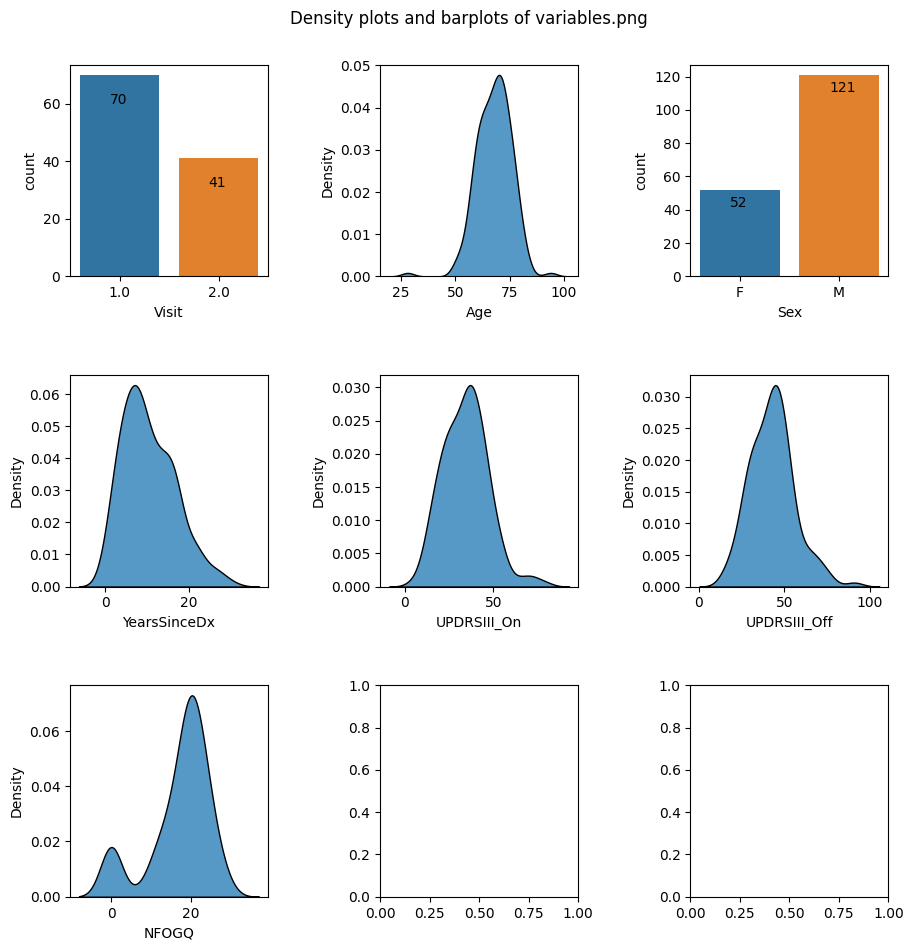

In [100]:
plot_var(subject, ['Subject'])

### Correlation

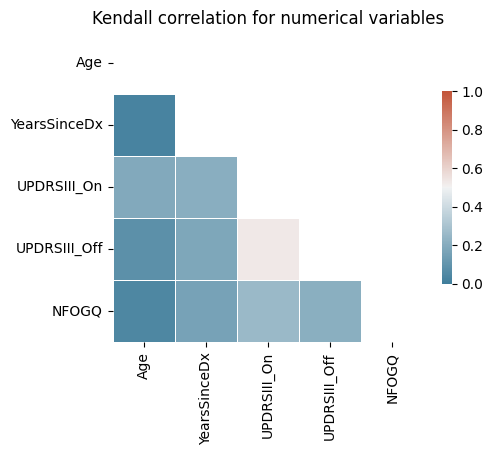

In [114]:
informative_col = ['Subject']
kendall_value_df = subject.drop(informative_col , axis=1).select_dtypes(exclude=['category']).corr(method='kendall')
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_correlation_matrix(kendall_value_df, axes, 'numerical')

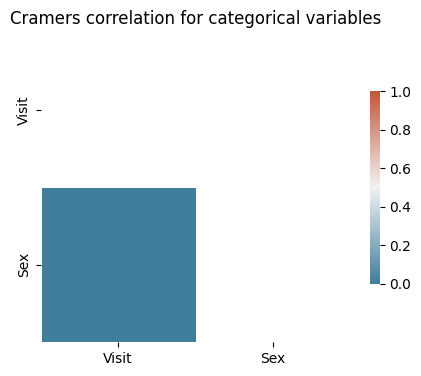

In [117]:
## Cramer test for categorical data
target_ = []
cramers_value_df = run_cramers(subject,target_, informative_col)  
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_correlation_matrix(cramers_value_df, axes, 'categorical')

In [ ]:
#correlation
corr = np.round(subject.select_dtypes(exclude='category').corr(),2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(X.select_dtypes(exclude='category').corr()))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize= (11,9))

# Draw the heatmap with 'sns.heatmap()'
sns.heatmap( corr, mask=mask, annot=True)

In [68]:
subject.iloc[:10]

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0
2,0967b2,1.0,59,M,10.0,38.0,48.0,19
3,0967b2,2.0,59,M,10.0,37.0,44.0,13
4,097078,NaN,70,F,10.0,27.0,50.0,20
5,0e0908,NaN,67,M,6.0,16.0,61.0,21
6,109122,2.0,75,F,3.0,22.0,24.0,12
7,109122,1.0,75,F,3.0,21.0,30.0,19
8,10943a,1.0,61,F,1.0,14.0,NaN,0
9,11404e,NaN,67,F,4.0,NaN,18.0,29


In [15]:
tdsc_test

,Time,AccV,AccML,AccAP
0,0,-9.533939,0.566322,-1.413525
1,1,-9.536140,0.564137,-1.440621
2,2,-9.529345,0.561765,-1.429332
3,3,-9.531239,0.564227,-1.415490
4,4,-9.540825,0.561854,-1.429471
...,...,...,...,...
4677,4677,-9.351431,0.370047,-2.286318
4678,4678,-9.341410,0.347721,-2.321991
4679,4679,-9.350667,0.361341,-2.297158
4680,4680,-9.343977,0.365726,-2.292650


In [14]:
daily_metadata

,Id,Subject,Visit,Beginning of recording [00:00-23:59]
0,00c4c9313d,3d8b73,1,10:19
1,07a96f89ec,a15b56,1,07:30
2,0d1bc672a8,21e523,2,08:30
3,0e333c9833,b068a2,1,11:30
4,164adaed7b,ffa798,1,13:00
...,...,...,...,...
60,e658b0aa3d,b7bd52,1,08:00
61,ed0a487f20,268a2e,1,12:30
62,ef1db3ca64,473568,1,08:00
63,f16c5cda55,b6a627,1,08:30


In [13]:
defog_train_1

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.000000,0.044129,-0.250000,0,0,0,False,False
1,1,-1.000000,0.034431,-0.250000,0,0,0,False,False
2,2,-1.000000,0.031250,-0.250000,0,0,0,False,False
3,3,-1.000000,0.031250,-0.250000,0,0,0,False,False
4,4,-1.000000,0.031250,-0.250000,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
162902,162902,-1.007283,0.234375,-0.375000,0,0,0,False,False
162903,162903,-1.000000,0.234375,-0.369159,0,0,0,False,False
162904,162904,-0.994626,0.234375,-0.351954,0,0,0,False,False
162905,162905,-0.977308,0.234375,-0.336683,0,0,0,False,False


In [12]:
defog_metadata

,Id,Subject,Visit,Medication
0,02ab235146,ab54e1,2,on
1,02ea782681,bf608b,2,on
2,06414383cf,c0b71e,2,off
3,092b4c1819,b6a627,1,off
4,0a900ed8a2,b7bd52,2,on
...,...,...,...,...
132,f3a921edee,ce8b0b,1,off
133,f40e8c6ebe,d9529b,1,off
134,f8ddbdd98d,fc1e1b,1,on
135,f9efef91fb,fe5d84,2,off


In [11]:
tdcsfod_metadata

,Id,Subject,Visit,Test,Medication
0,003f117e14,13abfd,3,2,on
1,009ee11563,d81e3a,4,2,on
2,011322847a,203e85,2,2,on
3,01d0fe7266,203e85,2,1,off
4,024418ba39,cecfb8,19,3,on
...,...,...,...,...,...
828,feba449e1a,47860d,19,1,on
829,ff4f844fd3,43fcae,2,3,on
830,ff53514514,a2a051,2,3,on
831,ff92d9244d,a9e866,20,2,on


In [17]:
tasks

,Id,Begin,End,Task
0,02ab235146,10.000,190.480,Rest1
1,02ab235146,211.240,271.560,Rest2
2,02ab235146,505.880,522.400,4MW
3,02ab235146,577.960,594.640,4MW-C
4,02ab235146,701.320,715.280,MB1
...,...,...,...,...
2812,f9fc61ce85,800.586,810.714,TUG-DT
2813,f9fc61ce85,904.416,926.181,Turning-ST
2814,f9fc61ce85,959.211,989.855,Turning-DT
2815,f9fc61ce85,1087.313,1105.086,Hotspot1


In [19]:
events

,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.61312,14.7731,Turn,1.0
1,009ee11563,11.38470,41.1847,Turn,1.0
2,009ee11563,54.66470,58.7847,Turn,1.0
3,011322847a,28.09660,30.2966,Turn,1.0
4,01d0fe7266,30.31840,31.8784,Turn,1.0
...,...,...,...,...,...
3707,f9fc61ce85,628.56000,631.6650,Walking,0.0
3708,f9fc61ce85,782.49800,782.6530,Walking,1.0
3709,f9fc61ce85,931.93900,933.4470,Turn,1.0
3710,f9fc61ce85,990.85900,991.8580,Turn,0.0


In [9]:
subject

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0
2,0967b2,1.0,59,M,10.0,38.0,48.0,19
3,0967b2,2.0,59,M,10.0,37.0,44.0,13
4,097078,NaN,70,F,10.0,27.0,50.0,20
...,...,...,...,...,...,...,...,...
168,f90887,1.0,72,M,16.0,35.0,46.0,26
169,fc1e1b,1.0,82,F,11.0,38.0,42.0,21
170,fe5d84,2.0,72,M,14.0,32.0,45.0,17
171,fe5d84,1.0,72,F,14.0,13.0,33.0,15


Here we will join meta data and events table there is information that can be useful in both

In [54]:
defog_meta_event = pd.merge(defog_metadata, events, how='left', on='Id')
tdcs_meta_event = pd.merge(tdcsfod_metadata, events, how='left', on='Id')
tdcs_meta_event

,Id,Subject,Visit,Test,Medication,Init,Completion,Type,Kinetic
0,003f117e14,13abfd,3,2,on,8.61312,14.7731,Turn,1.0
1,009ee11563,d81e3a,4,2,on,11.38470,41.1847,Turn,1.0
2,009ee11563,d81e3a,4,2,on,54.66470,58.7847,Turn,1.0
3,011322847a,203e85,2,2,on,28.09660,30.2966,Turn,1.0
4,01d0fe7266,203e85,2,1,off,30.31840,31.8784,Turn,1.0
...,...,...,...,...,...,...,...,...,...
1622,ff92d9244d,a9e866,20,2,on,347.32000,464.2000,Walking,1.0
1623,ff92d9244d,a9e866,20,2,on,464.20000,513.6000,Turn,1.0
1624,ff92d9244d,a9e866,20,2,on,513.60000,677.8000,Walking,1.0
1625,ff92d9244d,a9e866,20,2,on,677.80000,695.1400,Turn,1.0


In [52]:
defog_meta_event

,Id,Subject,Visit,Medication,Init,Completion,Type,Kinetic
0,02ab235146,ab54e1,2,on,1969.173,1972.535,NaN,NaN
1,02ab235146,ab54e1,2,on,2078.982,2080.524,NaN,NaN
2,02ab235146,ab54e1,2,on,2290.606,2291.952,NaN,NaN
3,02ab235146,ab54e1,2,on,2704.292,2704.770,NaN,NaN
4,02ab235146,ab54e1,2,on,2785.534,2785.774,NaN,NaN
...,...,...,...,...,...,...,...,...
2515,f9fc61ce85,a7d8c0,1,on,628.560,631.665,Walking,0.0
2516,f9fc61ce85,a7d8c0,1,on,782.498,782.653,Walking,1.0
2517,f9fc61ce85,a7d8c0,1,on,931.939,933.447,Turn,1.0
2518,f9fc61ce85,a7d8c0,1,on,990.859,991.858,Turn,0.0


In [53]:
id_event_miss_tdcs = np.unique(tdcs_meta_event.iloc[np.where(tdcs_meta_event.isnull()==True)[0].tolist()].Id).tolist()
id_event_miss_defog = np.unique(defog_meta_event.iloc[np.where(defog_meta_event.isnull()==True)[0].tolist()].Id).tolist()
print(len(id_event_miss_tdcs), len(id_event_miss_defog))

422 46


In [55]:
subject

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0
2,0967b2,1.0,59,M,10.0,38.0,48.0,19
3,0967b2,2.0,59,M,10.0,37.0,44.0,13
4,097078,NaN,70,F,10.0,27.0,50.0,20
...,...,...,...,...,...,...,...,...
168,f90887,1.0,72,M,16.0,35.0,46.0,26
169,fc1e1b,1.0,82,F,11.0,38.0,42.0,21
170,fe5d84,2.0,72,M,14.0,32.0,45.0,17
171,fe5d84,1.0,72,F,14.0,13.0,33.0,15


For defog and tdcs data we will concatenate them (all patients or file) and then merge will meta dataµ

In [4]:
#import all train data 
list_all = {'List_id_defog_brut':[],  'List_id_tdsc_brut':[] }
list_all['List_id_defog_brut'] = os.listdir(path='../data/tlvmc-parkinsons-freezing-gait-prediction/train/defog')
list_all['List_id_tdsc_brut'] = os.listdir(path='../data/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog')

# import all tdsc and defrog data 
n_tdsc = len(list_all['List_id_tdsc_brut'])
n_defog = len(list_all['List_id_defog_brut'])
path_defog = '../data/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
path_tdsc = '../data/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'
datas = {'data_defog': {str(i) : pd.read_csv(filepath_or_buffer=path_defog+str(i)) for i in list_all['List_id_defog_brut']},
             'data_tdsc': {str(i) : pd.read_csv(filepath_or_buffer=path_tdsc+str(i)) for i in list_all['List_id_tdsc_brut']}}


In [5]:
#add columns <with the keys of the merge
for i,j in datas['data_defog'].items():
    datas['data_defog'][str(i)]['Id_'] = str(i).replace('.csv', '')
for i,j in datas['data_tdsc'].items():
    datas['data_tdsc'][str(i)]['Id_'] = str(i).replace('.csv', '')   

In [6]:
#concat all the subject on one
tdsc = pd.concat(datas['data_tdsc'],ignore_index=True)
defog = pd.concat(datas['data_defog'],ignore_index=True)
#merge with subjet 
tdsc = pd.merge(tdsc, tdcsfod_metadata, how="left", left_on='Id_', right_on='Id')
defog = pd.merge(defog, defog_metadata, how="left", left_on='Id_', right_on='Id')
tdsc

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id_,Id,Subject,Visit,Test,Medication
0,0,-9.533939,0.566322,-1.413525,0,0,0,003f117e14,003f117e14,13abfd,3,2,on
1,1,-9.536140,0.564137,-1.440621,0,0,0,003f117e14,003f117e14,13abfd,3,2,on
2,2,-9.529345,0.561765,-1.429332,0,0,0,003f117e14,003f117e14,13abfd,3,2,on
3,3,-9.531239,0.564227,-1.415490,0,0,0,003f117e14,003f117e14,13abfd,3,2,on
4,4,-9.540825,0.561854,-1.429471,0,0,0,003f117e14,003f117e14,13abfd,3,2,on
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7062667,4220,-9.403467,0.089003,-3.220304,0,0,0,ffda8fadfd,ffda8fadfd,bae0ce,20,1,off
7062668,4221,-9.404246,0.090531,-3.216584,0,0,0,ffda8fadfd,ffda8fadfd,bae0ce,20,1,off
7062669,4222,-9.405770,0.084380,-3.224039,0,0,0,ffda8fadfd,ffda8fadfd,bae0ce,20,1,off
7062670,4223,-9.403579,0.084236,-3.236686,0,0,0,ffda8fadfd,ffda8fadfd,bae0ce,20,1,off


In [7]:
tdsc_ = tdsc.drop(columns=['Id_','Id','Subject','Test','Visit','Medication'])
tdsc_

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.533939,0.566322,-1.413525,0,0,0
1,1,-9.536140,0.564137,-1.440621,0,0,0
2,2,-9.529345,0.561765,-1.429332,0,0,0
3,3,-9.531239,0.564227,-1.415490,0,0,0
4,4,-9.540825,0.561854,-1.429471,0,0,0
...,...,...,...,...,...,...,...
7062667,4220,-9.403467,0.089003,-3.220304,0,0,0
7062668,4221,-9.404246,0.090531,-3.216584,0,0,0
7062669,4222,-9.405770,0.084380,-3.224039,0,0,0
7062670,4223,-9.403579,0.084236,-3.236686,0,0,0


In [8]:
#select only valid defog data 
defog_val = defog[defog.Valid == True][defog.Task == True]
defog_val 

C:\Users\mehdy\AppData\Local\Temp\ipykernel_1632\473817478.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  defog_val = defog[defog.Valid == True][defog.Task == True]


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,Id_,Id,Subject,Visit,Medication
1000,1000,-0.970018,0.061626,-0.265625,0,0,0,True,True,02ea782681,02ea782681,bf608b,2,on
1001,1001,-0.984375,0.044497,-0.265625,0,0,0,True,True,02ea782681,02ea782681,bf608b,2,on
1002,1002,-0.984375,0.029016,-0.265625,0,0,0,True,True,02ea782681,02ea782681,bf608b,2,on
1003,1003,-0.984375,0.015625,-0.265625,0,0,0,True,True,02ea782681,02ea782681,bf608b,2,on
1004,1004,-0.984670,0.015330,-0.265625,0,0,0,True,True,02ea782681,02ea782681,bf608b,2,on
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13524697,119027,-0.961216,0.142428,-0.289655,0,0,0,True,True,f9fc61ce85,f9fc61ce85,a7d8c0,1,on
13524698,119028,-0.960343,0.142836,-0.290506,0,0,0,True,True,f9fc61ce85,f9fc61ce85,a7d8c0,1,on
13524699,119029,-0.957958,0.145494,-0.290007,0,0,0,True,True,f9fc61ce85,f9fc61ce85,a7d8c0,1,on
13524700,119030,-0.960616,0.145839,-0.291527,0,0,0,True,True,f9fc61ce85,f9fc61ce85,a7d8c0,1,on


In [9]:
defog_notype = defog.loc[set(defog.index)- set(defog_val.index)]
defog_notype

C:\Users\mehdy\AppData\Local\Temp\ipykernel_1632\1441729205.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  defog_notype = defog.loc[set(defog.index)- set(defog_val.index)]


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,Id_,Id,Subject,Visit,Medication
0,0,-1.000000,0.044129,-0.250000,0,0,0,False,False,02ea782681,02ea782681,bf608b,2,on
1,1,-1.000000,0.034431,-0.250000,0,0,0,False,False,02ea782681,02ea782681,bf608b,2,on
2,2,-1.000000,0.031250,-0.250000,0,0,0,False,False,02ea782681,02ea782681,bf608b,2,on
3,3,-1.000000,0.031250,-0.250000,0,0,0,False,False,02ea782681,02ea782681,bf608b,2,on
4,4,-1.000000,0.031250,-0.250000,0,0,0,False,False,02ea782681,02ea782681,bf608b,2,on
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13525697,120027,-0.962333,0.113288,-0.328300,0,0,0,False,False,f9fc61ce85,f9fc61ce85,a7d8c0,1,on
13525698,120028,-0.962351,0.109235,-0.324841,0,0,0,False,False,f9fc61ce85,f9fc61ce85,a7d8c0,1,on
13525699,120029,-0.956052,0.101676,-0.324484,0,0,0,False,False,f9fc61ce85,f9fc61ce85,a7d8c0,1,on
13525700,120030,-0.951245,0.097876,-0.322607,0,0,0,False,False,f9fc61ce85,f9fc61ce85,a7d8c0,1,on


In [10]:
len(defog_notype)+len(defog_val) == len(defog)

True

## Two data defog and tdsc analysis 

### Defog

defog database is the dataset comprising data series collected in the subject's home, as subjects completed a FOG-provoking protocol 
defog val is the defog with only Valid == Task == True 
Size : 41113222 rows and 10 variables 
- Time the second for the check FOG 
- AccV, AccML, and AccAP Acceleration from a lower-back sensor on three axes: V - vertical, ML - mediolateral, AP - anteroposterior. Data is in units of g 
- StartHesitation, Turn, Walking Indicator variables for the occurrence of each of the event types.
- Medication Subjects may have been either off or on anti-parkinsonian medication during the recording.
- Visit Lab visits consist of a baseline assessment, two post-treatment assessments for different treatment stages, and one follow-up assessment.


In [11]:
defog_model = defog_val.drop(columns=['Id','Id_','Task','Valid'] )
defog_model 

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Subject,Visit,Medication
1000,1000,-0.970018,0.061626,-0.265625,0,0,0,bf608b,2,on
1001,1001,-0.984375,0.044497,-0.265625,0,0,0,bf608b,2,on
1002,1002,-0.984375,0.029016,-0.265625,0,0,0,bf608b,2,on
1003,1003,-0.984375,0.015625,-0.265625,0,0,0,bf608b,2,on
1004,1004,-0.984670,0.015330,-0.265625,0,0,0,bf608b,2,on
...,...,...,...,...,...,...,...,...,...,...
13524697,119027,-0.961216,0.142428,-0.289655,0,0,0,a7d8c0,1,on
13524698,119028,-0.960343,0.142836,-0.290506,0,0,0,a7d8c0,1,on
13524699,119029,-0.957958,0.145494,-0.290007,0,0,0,a7d8c0,1,on
13524700,119030,-0.960616,0.145839,-0.291527,0,0,0,a7d8c0,1,on


In [12]:
cat = ['Time','StartHesitation','Turn','Walking','Visit','Medication']
defog_model[cat] = defog_model[cat].astype('category')
effectif_int(defog_model)

,mean,std,min,25%,50%,75%,max
AccV,-0.934887,0.106942,-6.024701,-0.985084,-0.939016,-0.886941,4.458365
AccML,-0.001301,0.139912,-2.115008,-0.084684,0.000000,0.092099,4.524038
AccAP,-0.226019,0.244200,-5.118650,-0.363919,-0.250000,-0.113508,4.388132


In [13]:
descriptiv_ = Descriptive_analysis()
descriptiv_.missing_values(defog_model)

There is no missing values


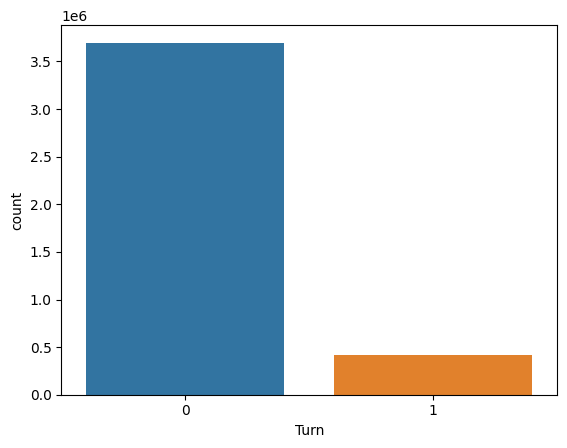

In [14]:
data = defog_model.drop(columns='Subject')
g = sns.countplot(data=  data, x='Turn')

AccV
AccML
AccAP
StartHesitation
Turn
Walking
Visit
Medication


Text(0.5, 0.98, 'Density plots and barplots of variables.png')

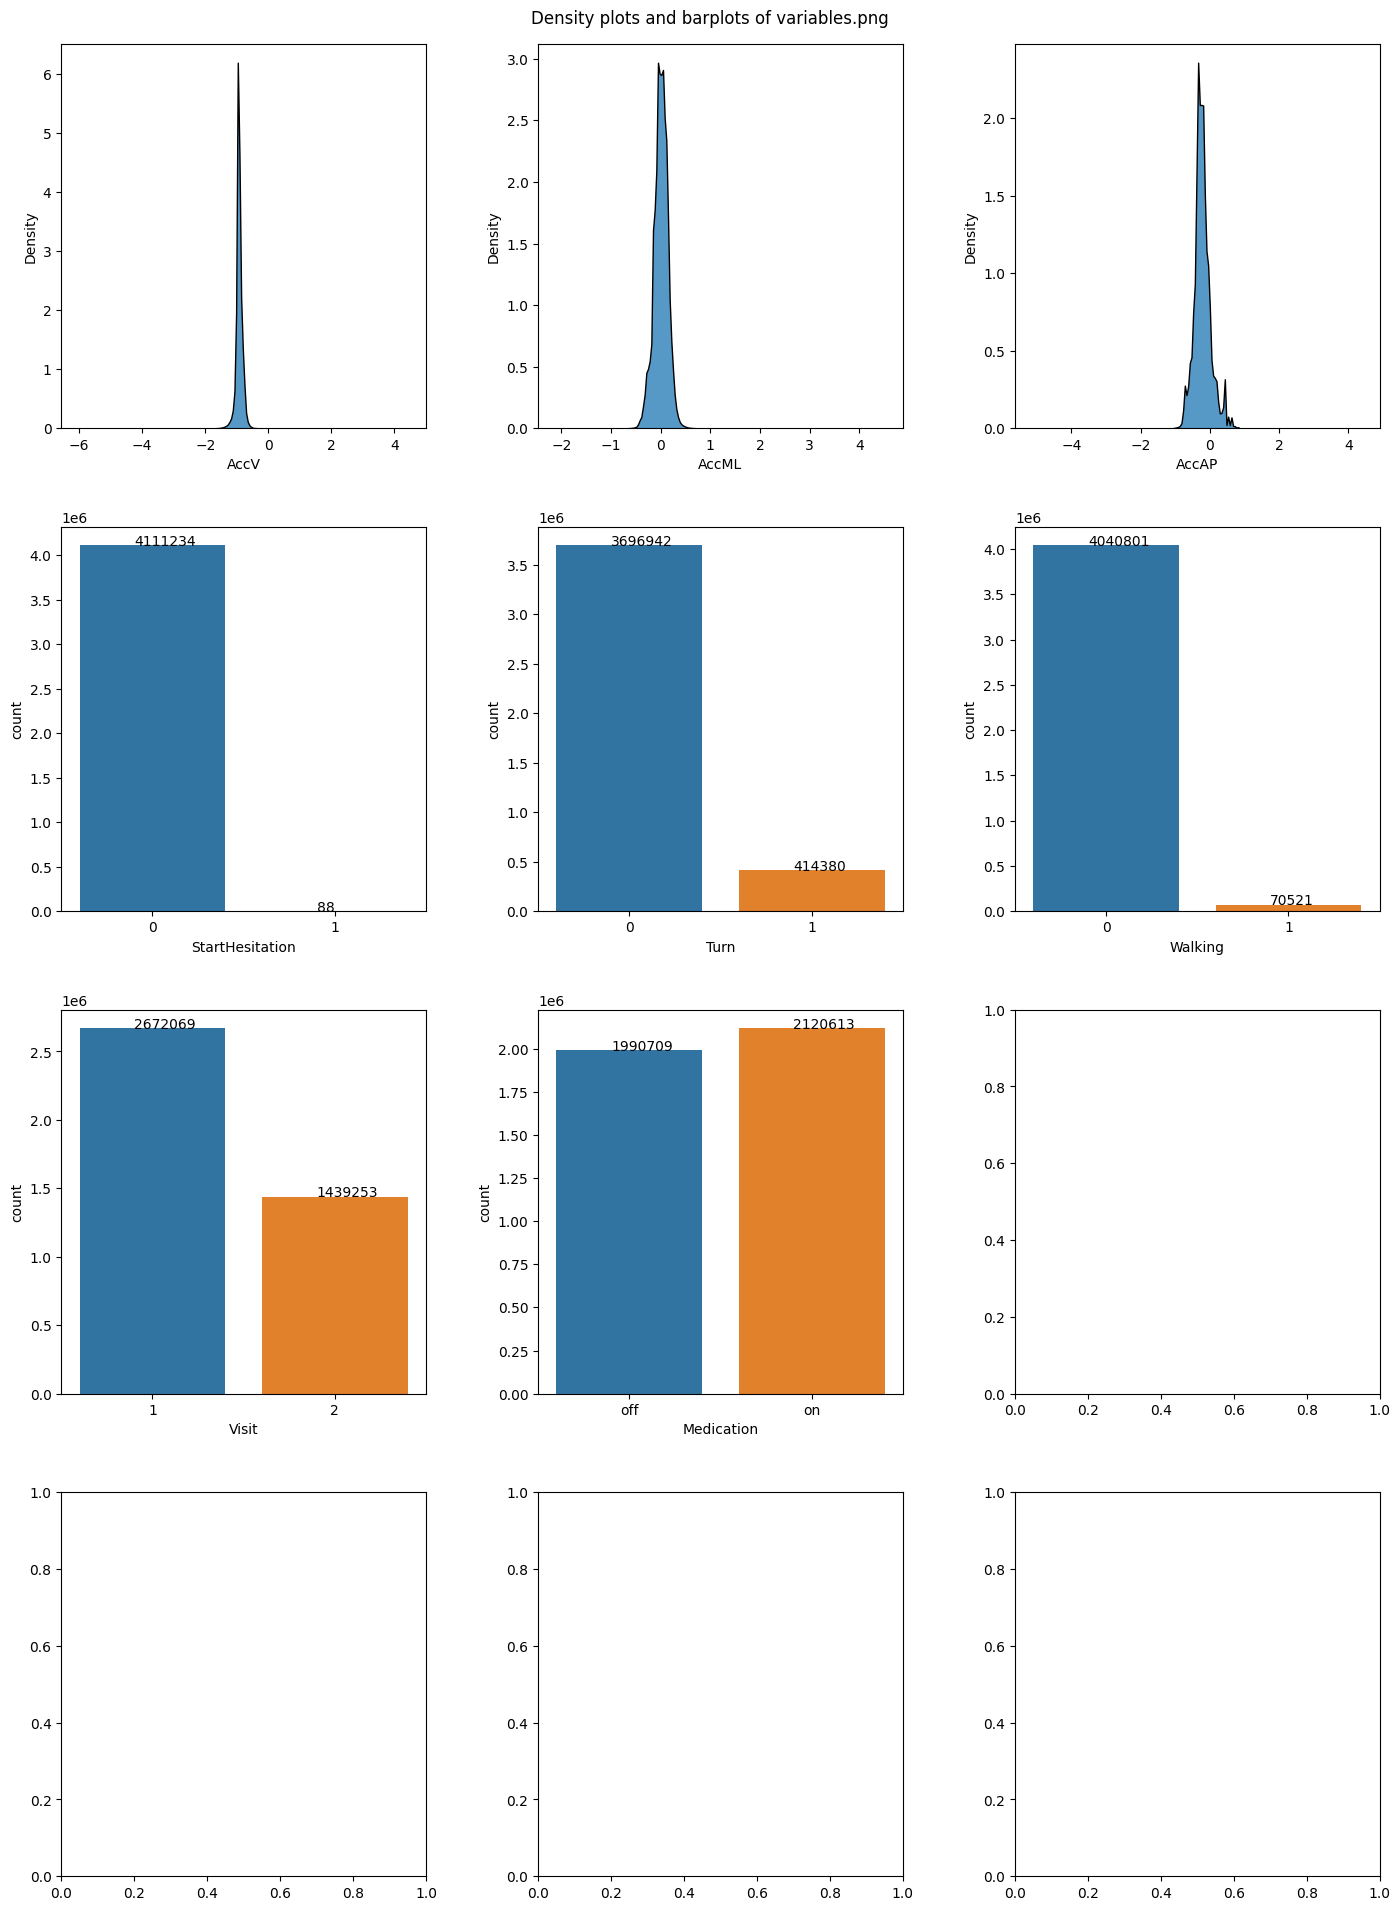

In [15]:
data = defog_model.drop(columns=['Subject','Time'])
y = None
N_features = 10
N_col = 3
if N_features%N_col == 0:
    n_rows = np.int64(N_features/N_col)
else:
    n_rows = np.int64(N_features/N_col) + 1

# plot recursivly according to the type of variables
fig, ax = plt.subplots(nrows=n_rows, ncols=N_col, figsize = (15,20))
fig.tight_layout(pad=5.0)
ind_row = 0
ind_col = 0
for i in data.columns:
    print(i)
    if N_col == ind_col:
        ind_col = 0 
        ind_row += 1 
    if i in data.select_dtypes('category').columns.tolist():
        g = sns.countplot(data=  data, x=str(i), ax=ax[ind_row][ind_col], hue=y)
        #g.set(ylim=(0, 150))
        for p in ax[ind_row][ind_col].patches:
            ax[ind_row][ind_col].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+10))
        ind_col += 1  
    elif i in data.select_dtypes(exclude='category').columns.tolist():
        g = sns.kdeplot(data =  data, x=str(i), hue=y, ax=ax[ind_row][ind_col], multiple="stack")
        ind_col +=1


title = "Density plots and barplots of variables.png"
plt.suptitle(str(title))

### Basic prediction multilabel

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [56]:
data2 = tdsc_[:]
data2

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.533939,0.566322,-1.413525,0,0,0
1,1,-9.536140,0.564137,-1.440621,0,0,0
2,2,-9.529345,0.561765,-1.429332,0,0,0
3,3,-9.531239,0.564227,-1.415490,0,0,0
4,4,-9.540825,0.561854,-1.429471,0,0,0
...,...,...,...,...,...,...,...
7062667,4220,-9.403467,0.089003,-3.220304,0,0,0
7062668,4221,-9.404246,0.090531,-3.216584,0,0,0
7062669,4222,-9.405770,0.084380,-3.224039,0,0,0
7062670,4223,-9.403579,0.084236,-3.236686,0,0,0


In [57]:
X1, y1 = data2[['Time','AccV','AccML','AccAP']], data2[['StartHesitation','Turn','Walking']]
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1 , y1, test_size=0.33 , random_state=40)
ytrain1 = ytrain1.astype('int')
ytrain1 = ytrain1.reset_index()

In [60]:
rf1 = DecisionTreeClassifier(random_state=42)
rf1.fit(Xtrain1, ytrain1)
ypred1 = rf1.predict(Xtest1)

: 

: 

#### Defog

In [17]:
data = defog_model.drop(columns=['Subject'])

In [18]:
X, y = data[['Time','AccV','AccML','AccAP']], data[['StartHesitation','Turn','Walking']]
Xtrain, Xtest, ytrain, ytest = train_test_split(X , y, test_size=0.33 , random_state=40)

In [39]:
ytrain = ytrain.astype('int')
y = y.astype('int')

In [20]:
X

,Time,AccV,AccML,AccAP
1000,1000,-0.970018,0.061626,-0.265625
1001,1001,-0.984375,0.044497,-0.265625
1002,1002,-0.984375,0.029016,-0.265625
1003,1003,-0.984375,0.015625,-0.265625
1004,1004,-0.984670,0.015330,-0.265625
...,...,...,...,...
13524697,119027,-0.961216,0.142428,-0.289655
13524698,119028,-0.960343,0.142836,-0.290506
13524699,119029,-0.957958,0.145494,-0.290007
13524700,119030,-0.960616,0.145839,-0.291527


In [19]:
defog_test

,Time,AccV,AccML,AccAP
0,0,-0.914652,-0.300851,0.298156
1,1,-0.914367,-0.301572,0.298325
2,2,-0.779540,-0.343197,0.275690
3,3,-0.993162,-0.270281,0.315775
4,4,-0.948767,-0.307849,0.297191
...,...,...,...,...
281683,281683,-0.899299,-0.232668,0.389147
281684,281684,-0.901973,-0.233051,0.390114
281685,281685,-0.901690,-0.231888,0.391896
281686,281686,-0.899576,-0.232429,0.391106


In [23]:
y = y.reset_index()

In [24]:
rf = DecisionTreeClassifier()
rf.fit(X, y)
ypred = rf.predict(defog_test)

In [40]:
rf = DecisionTreeClassifier()
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

In [44]:
ypred = pd.DataFrame(ypred)
ypred.columns = ['StartHesitation','Turn','Walking']
ypred

,StartHesitation,Turn,Walking
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1356732,0,0,0
1356733,0,0,0
1356734,0,0,0
1356735,0,1,0


In [50]:
ytest = ytest.reset_index()

In [54]:
sum(ytest['StartHesitation'] != ypred['StartHesitation']) / len(ytest)
sum(ytest['Turn'] != ypred['Turn']) / len(ytest)
sum(ytest['Walking'] != ypred['Walking']) / len(ytest)

0.008110636033365346

In [106]:
tdsc.drop(columns='Id', inplace=True)
tdsc

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id_,Subject,Visit,Test,Medication
0,0,-9.533939,0.566322,-1.413525,0,0,0,003f117e14,13abfd,3,2,on
1,1,-9.536140,0.564137,-1.440621,0,0,0,003f117e14,13abfd,3,2,on
2,2,-9.529345,0.561765,-1.429332,0,0,0,003f117e14,13abfd,3,2,on
3,3,-9.531239,0.564227,-1.415490,0,0,0,003f117e14,13abfd,3,2,on
4,4,-9.540825,0.561854,-1.429471,0,0,0,003f117e14,13abfd,3,2,on
...,...,...,...,...,...,...,...,...,...,...,...,...
7062667,4220,-9.403467,0.089003,-3.220304,0,0,0,ffda8fadfd,bae0ce,20,1,off
7062668,4221,-9.404246,0.090531,-3.216584,0,0,0,ffda8fadfd,bae0ce,20,1,off
7062669,4222,-9.405770,0.084380,-3.224039,0,0,0,ffda8fadfd,bae0ce,20,1,off
7062670,4223,-9.403579,0.084236,-3.236686,0,0,0,ffda8fadfd,bae0ce,20,1,off


The first data is **subject** that contains metadata for each subject in the study with 8 variables with 173 patients :
- Subject the id of the patient
- Visit : number of visit for assement
- Age and Sex : the age and the sex of the patients 
- YearsSinceDx : Years since parkinson's diagnoisis
- UPDRSIIIOn/UPDRSIIIOff Unified Parkinson's Disease Rating Scale score during on/off medication respectively.
- NFOGQ Self-report FoG questionnaire score

In [21]:
defog_metadata

,Id,Subject,Visit,Medication
0,02ab235146,ab54e1,2,on
1,02ea782681,bf608b,2,on
2,06414383cf,c0b71e,2,off
3,092b4c1819,b6a627,1,off
4,0a900ed8a2,b7bd52,2,on
...,...,...,...,...
132,f3a921edee,ce8b0b,1,off
133,f40e8c6ebe,d9529b,1,off
134,f8ddbdd98d,fc1e1b,1,on
135,f9efef91fb,fe5d84,2,off


In [22]:
defog_train_1

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.000000,0.044129,-0.250000,0,0,0,False,False
1,1,-1.000000,0.034431,-0.250000,0,0,0,False,False
2,2,-1.000000,0.031250,-0.250000,0,0,0,False,False
3,3,-1.000000,0.031250,-0.250000,0,0,0,False,False
4,4,-1.000000,0.031250,-0.250000,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
162902,162902,-1.007283,0.234375,-0.375000,0,0,0,False,False
162903,162903,-1.000000,0.234375,-0.369159,0,0,0,False,False
162904,162904,-0.994626,0.234375,-0.351954,0,0,0,False,False
162905,162905,-0.977308,0.234375,-0.336683,0,0,0,False,False


In [4]:
subject.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0
2,0967b2,1.0,59,M,10.0,38.0,48.0,19
3,0967b2,2.0,59,M,10.0,37.0,44.0,13
4,097078,NaN,70,F,10.0,27.0,50.0,20


## Data subject descriptive analysis
### Missing values 

In [5]:
descriptive = Descriptive_analysis()
descriptive.missing_values(X = subject)

,Variables,Nans
0,Visit,62
1,UPDRSIII_Off,41
2,UPDRSIII_On,1


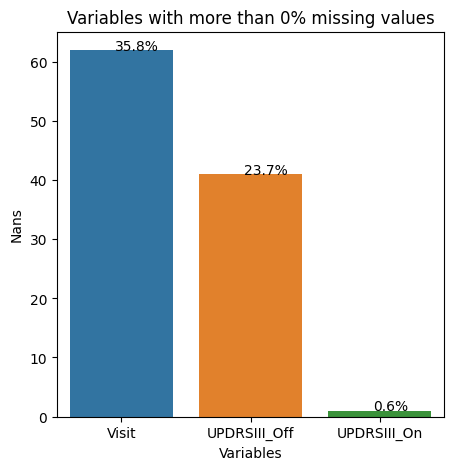

In [6]:
descriptive.plot_missing_values(X = subject, threshold=0, fig_size=[5,5])

There is no variable that have more than 50% of missing values .
How to deal with the missing values for visit ? 

In [9]:
subject[['Visit', 'Sex']] = subject[['Visit', 'Sex']].astype('category')
type_of_vars(subject)

,Types variables
Subject,object
Visit,category
Age,int64
Sex,category
YearsSinceDx,float64
UPDRSIII_On,float64
UPDRSIII_Off,float64
NFOGQ,int64


In [10]:
effectif_int(subject)

,mean,std,min,25%,50%,75%,max
Age,67.763006,7.972075,28.00,62.0,68.0,73.00,94.0
YearsSinceDx,10.383931,6.289191,0.42,6.0,9.0,15.00,30.0
UPDRSIII_On,34.273256,12.732552,5.00,25.0,35.0,42.25,79.0
UPDRSIII_Off,42.878788,12.998550,15.00,33.0,43.0,49.25,91.0
NFOGQ,17.121387,7.575377,0.00,15.0,19.0,22.00,29.0


the mean of age for thoses patients is around 68 years old, and the average of years of disease is 10 years. We can see that the mean of the  Unified Parkinson's Disease Rating Scale score on medication is lower than off medication (34 vs 43)

### Graphics 

Text(0.5, 0.98, 'Density plots and barplots of variables.png')

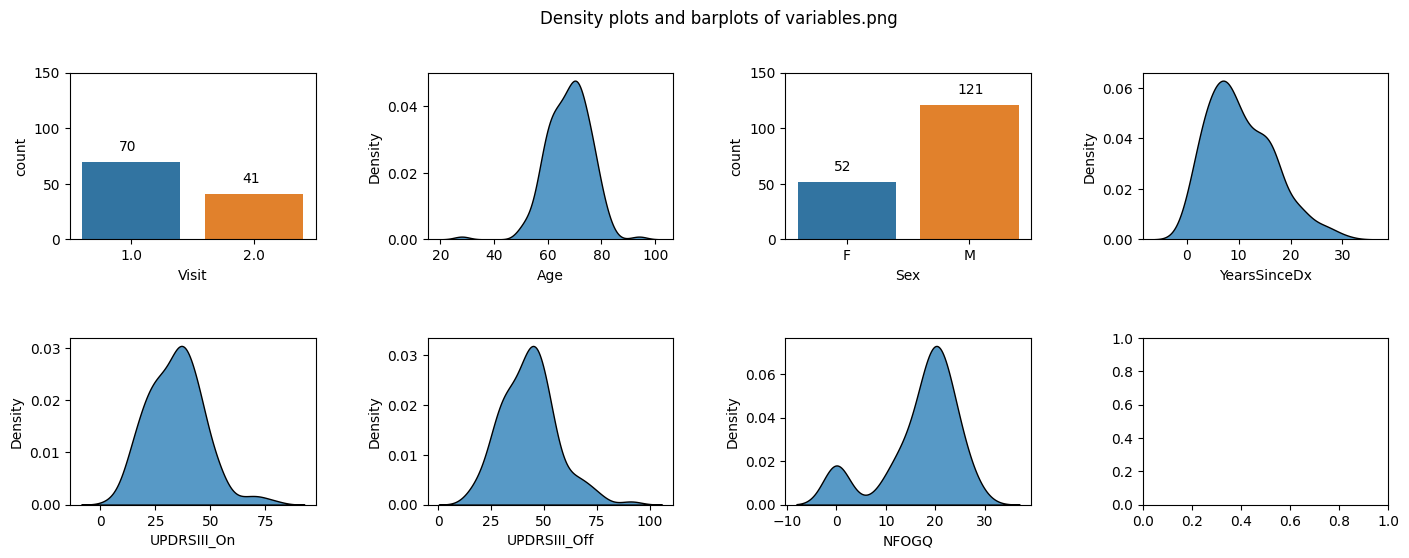

In [20]:
c

In [20]:
defog_train_1

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.000000,0.044129,-0.250000,0,0,0,False,False
1,1,-1.000000,0.034431,-0.250000,0,0,0,False,False
2,2,-1.000000,0.031250,-0.250000,0,0,0,False,False
3,3,-1.000000,0.031250,-0.250000,0,0,0,False,False
4,4,-1.000000,0.031250,-0.250000,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
162902,162902,-1.007283,0.234375,-0.375000,0,0,0,False,False
162903,162903,-1.000000,0.234375,-0.369159,0,0,0,False,False
162904,162904,-0.994626,0.234375,-0.351954,0,0,0,False,False
162905,162905,-0.977308,0.234375,-0.336683,0,0,0,False,False


In [17]:
daily_metadata

,Id,Subject,Visit,Beginning of recording [00:00-23:59]
0,00c4c9313d,3d8b73,1,10:19
1,07a96f89ec,a15b56,1,07:30
2,0d1bc672a8,21e523,2,08:30
3,0e333c9833,b068a2,1,11:30
4,164adaed7b,ffa798,1,13:00
...,...,...,...,...
60,e658b0aa3d,b7bd52,1,08:00
61,ed0a487f20,268a2e,1,12:30
62,ef1db3ca64,473568,1,08:00
63,f16c5cda55,b6a627,1,08:30


In [15]:
defog_train_1

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.000000,0.044129,-0.250000,0,0,0,False,False
1,1,-1.000000,0.034431,-0.250000,0,0,0,False,False
2,2,-1.000000,0.031250,-0.250000,0,0,0,False,False
3,3,-1.000000,0.031250,-0.250000,0,0,0,False,False
4,4,-1.000000,0.031250,-0.250000,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
162902,162902,-1.007283,0.234375,-0.375000,0,0,0,False,False
162903,162903,-1.000000,0.234375,-0.369159,0,0,0,False,False
162904,162904,-0.994626,0.234375,-0.351954,0,0,0,False,False
162905,162905,-0.977308,0.234375,-0.336683,0,0,0,False,False
